<a href="https://colab.research.google.com/github/opherdonchin/Regression-by-group/blob/main/Regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample homogeneous and intercept models for slope of eyes and aftereffects

## Short description

The central idea is that eye movements reflect the implicit adaptation that is also revealed in the aftereffects. Thus, these two should be correlated. 
We measure the relationship using regression (I suppose we could have done correlation, eh?) and look at the slope of the regession line. However, because
both measures are quite noisy, we choose to have an error model for both the independent and dependent variables.

There are 2 different conditions in terms of what is on the screen (landmark or no landmarks) and each of those has multiple delay conditions (2 for landmarks (I think) 
and 3 for no landmarks (or the other way around)). The idea is to build separate (but identical) models for each of these 5 conditions and for each one to fit both an
intercept and homogeneous model.

So, there are two questions:

1. Is there a reason to prefer the intercept model to the homogeneous model?
2. Do any of the conditions show a relationship and do any show a lack of relationship?

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

## Imports

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pymc3
    !pip install seaborn
    !pip install arviz

In [2]:
# Imports
# Python
import os.path
import pickle

# Maths
import numpy as np
import pandas as pd
import scipy.stats as stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Bayes
import aesara.tensor as tt
import xarray as xr
import pymc as pm
import arviz as az


In [3]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v4.0.1


## Load data

In [4]:
# url_impl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_expl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_impl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
# url_expl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
# url_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataLandmarks.csv'
# url_no_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataNoLandmarks.csv'
url_landmarks = 'data\dataLandmarks.csv'
url_no_landmarks = 'data\dataNoLandmarks.csv'

landmark_data = pd.read_csv(url_landmarks, sep=",", on_bad_lines='skip')
no_landmark_data = pd.read_csv(url_no_landmarks, sep=",", on_bad_lines='skip')

In [5]:
landmark_data.head()

,eyeHandDiff,eyes,afterEffect,subjectN,groups
0,10.082297,-31.546520,-8.875644,1,1
1,-10.012122,-27.271097,-3.625990,1,1
2,-33.441301,14.607681,-15.002860,1,1
3,-95.241374,57.084439,-11.144006,1,1
4,-121.630474,99.886312,-17.726672,1,1


## Create list of models

In [5]:
landmark_data["landmarks"] = True
no_landmark_data["landmarks"] = False
data = pd.concat([landmark_data, no_landmark_data], ignore_index=True)

independent_variables = ['eyeHandDiff', 'eyes']
x0_by_variable = [0, -30]
y0_by_variable = [0, 0]

b0_strings = ["intercept", "homogeneous"]

model_list = {b0_string: [] for b0_string in b0_strings}
for independent_variable,x0,y0 in zip(independent_variables,x0_by_variable,y0_by_variable):
    
    for landmarks in [True, False]:
        landmark_string = "landmarks" if landmarks else "no landmarks"
        this_landmark_data = data.loc[data["landmarks"]==landmarks,:]
        these_groups = this_landmark_data["groups"].unique()
        for group in these_groups:
            this_group_data = this_landmark_data.loc[data["groups"]==group,:]
            x = this_group_data[independent_variable]
            y = this_group_data['afterEffect']
            s = this_group_data['subjectN']
            
            for b0_string in b0_strings:
                model_name = f'{landmark_string} group {group} {b0_string} using {independent_variable}'
                model_list[b0_string].append({
                    'name': model_name,
                    'group': group,
                    'landmarks': landmark_string,
                    'variable': independent_variable,
                    'x': x,
                    'y': y,
                    's': s,
                    'x0': x0,
                    'y0': y0,
                    'use_b0': b0_string == b0_strings[0]
                })

model_list_out = open("model_list.pickle","wb")
pickle.dump(model_list, model_list_out)

## Define model

In [25]:
def regression_model(y,x,s,y0,x0,use_beta0):
  s_idx, s_vals = pd.factorize(s, sort=True)
  coords = {"subject": s_vals, "points":np.arange(len(x))}
  with pm.Model(coords=coords) as model:
    # Data
    s_idx = pm.Data("s_idx", s_idx, dims="points")
    x0 = pm.Data("x0", x0)
    y0 = pm.Data("y0", y0)
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=10)
    if use_beta0:
      beta0 = pm.Normal('beta0', mu=0, sigma=30)
    y_sigma = pm.HalfNormal("y_sigma", sigma=5, dims="subject")
    x_sigma = pm.HalfNormal("x_sigma", sigma=5, dims="subject")
    ys_sigma = pm.HalfNormal("ys_sigma", sigma=5)
    # Latent variables
    xs = pm.Normal('xs', mu=0, sigma=30, dims="subject")
    if use_beta0:
      ys_mu = pm.Deterministic("ys_mu", beta*(xs-x0) + beta0+y0, dims="subject")
    else:
      ys_mu = pm.Deterministic("ys_mu", beta*(xs-x0) + y0, dims="subject")
    
    ys = pm.Normal('ys', mu=ys_mu, sigma=ys_sigma, dims="subject")
    # Likelihood 
    obs_y = pm.Normal('obs_y', mu=ys[s_idx], sigma=y_sigma[s_idx], observed=y, dims="points")
    obs_x = pm.Normal('obs_x', mu=xs[s_idx], sigma=x_sigma[s_idx], observed=x, dims="points")
  return model


## Sample all models

In [ ]:
all_idata = {b0_string: [] for b0_string in b0_strings}
num_models = len(model_list[b0_strings[0]])

do_models = np.arange(0,num_models)
for b0_string in b0_strings:
  for i,m in enumerate(model_list[b0_string]):
    print('************************')
    trace_path = f'samples\\y_sigma 02_07 {m["name"]}'
    m['trace_path'] = trace_path
    model_description = f'{m["name"]} ({i}/{num_models} for {b0_string} model)'
    if not os.path.isfile(trace_path):
      print(f'Resampling {model_description}')
      model = regression_model(m["y"],m["x"],m["s"],m["y0"],m["x0"],m["use_b0"])
      with model:
        trace = pm.sample(draws=4000, tune=3000, cores=3, target_accept=0.95, return_inferencedata=True)
      idata = az.from_pymc3(model=model, trace=trace)
      
      print(f'Saving samples for {m["name"]} to {trace_path}')
      az.to_netcdf(idata, trace_path)
    else:
      print(f'Loading samples for {model_description} from {trace_path}')
      idata = az.from_netcdf(trace_path)
    
    all_idata[b0_string].append(idata)
    print(f'Done getting {m["name"]} samples')
  

### Show traces

In [ ]:
for i in range(num_models):
  for b0_string in b0_strings:
    trace = all_idata[b0_string][i]
    m = model_list[b0_string][i]
    ax = az.plot_trace(trace)
    ax[0][0].get_figure().suptitle(f'{m["name"]}')

## Plot regressions

<AxesSubplot:>

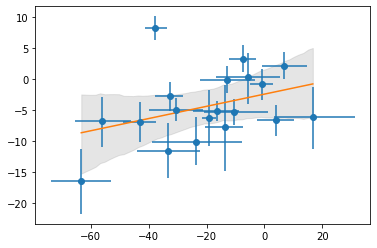

In [7]:
def plot_regression(data: az.InferenceData, m : pd.DataFrame, ax: plt.Axes = None):
    post = data.posterior

    post_mean = post[["xs","ys"]].mean(dim=['chain', 'draw'])
    post_hdi = az.hdi(post[["xs","ys"]])

    x_mean = post_mean["xs"]
    y_mean = post_mean["ys"]
    x_upper = post_hdi["xs"].sel({"hdi":"higher"}) - x_mean
    x_lower = x_mean - post_hdi["xs"].sel({"hdi":"lower"})
    y_upper = post_hdi["ys"].sel({"hdi":"higher"}) - y_mean
    y_lower = y_mean - post_hdi["ys"].sel({"hdi":"lower"})
        
    if ax is None:
        ax = plt.gca()

    ax.errorbar(x_mean, y_mean, xerr=[x_lower, x_upper], yerr=[y_lower, y_upper], fmt='o')

    x_hat = np.linspace(np.min(x_mean), np.max(x_mean), 50)
    x0 = m["x0"]
    y0 = m["y0"]
    beta = post["beta"].mean().to_numpy()
    if m["use_b0"]:
        beta0 = post["beta0"].mean().to_numpy()
    else:
        beta0 = 0

    y_hat = (x_hat-x0)*beta+beta0 + y0

    ax.plot(x_hat, y_hat)

    # az.plot_hdi(post["xs"], post["ys"])

    beta_trace = post["beta"]
    if m["use_b0"]:
        beta0_trace = post["beta0"]
    else:
        beta0_trace = 0

    y_lower = list()
    y_higher = list()
    for x_mod in x_hat:
        y_mod_trace = beta_trace*(x_mod-x0) + beta0_trace + y0
        y_mod_hdi = az.hdi(y_mod_trace).to_array().to_numpy()
        y_lower.append(y_mod_hdi[0][0])
        y_higher.append(y_mod_hdi[0][1])
    ax.fill_between(x_hat, y_lower, y_higher, color='grey', alpha=0.2)
    return ax

plot_regression(all_idata['intercept'][0], model_list['intercept'][0])

In [ ]:
num_models_per_variable = int(num_models/2)
num_variables = 2

for var_num in range(num_variables):
  fig, ax = plt.subplots(nrows=num_models_per_variable, ncols=2, figsize=(15, 20), sharex=True, sharey=True)
  for i in range(num_models_per_variable):
    mi = var_num*num_models_per_variable+i
    for j,b0_string in enumerate(b0_strings):
      trace = all_idata[b0_string][mi]
      m = model_list[b0_string][mi]
      plot_regression(data=trace, m=m, ax=ax[i,j])
      ax[i,j].grid()
      ax[i,j].set_title(m["name"])


## Calculate log likelihood for `ys`

In [8]:
def calc_ll(idata):
    x = (idata.observed_data["obs_x"]-m["x0"])
    y = idata.observed_data["obs_y"]-m["y0"]
    s_idx = idata.constant_data["s_idx"]
    xs = idata.posterior["xs"]
    ys = idata.posterior["ys"]
    ys_mu = idata.posterior["ys_mu"]
    x_sigma = idata.posterior["x_sigma"]
    y_sigma = idata.posterior["y_sigma"]
    ys_sigma = idata.posterior["ys_sigma"]


    ys_mu, ys_sigma = xr.broadcast(ys_mu, ys_sigma)
    ll_ys = stats.norm(ys_mu, ys_sigma).logpdf(ys)

    ll_x = np.zeros_like(ll_ys)
    ll_y = np.zeros_like(ll_ys)

    x_subj = x.groupby(s_idx)
    y_subj = y.groupby(s_idx)
    coords = idata.posterior.coords
    for c in coords["chain"]:
        print(f'Chain: {c.item()}')
        for d in coords["draw"]:
            for s in range(len(x_subj)):
                ll_x[c,d,s] = stats.norm(xs[c, d, s], x_sigma[c, d, s]).logpdf(x_subj[s]).sum()
                ll_y[c,d,s] = stats.norm(ys[c, d, s], y_sigma[c, d, s]).logpdf(y_subj[s]).sum()

    ll = ll_ys + ll_x + ll_y

    return xr.DataArray(ll, coords=ys.coords, dims=ys.dims)




In [ ]:

for mi in range(num_models):
    for j,b0_string in enumerate(b0_strings):
        m = model_list[b0_string][mi]
        print(f'{b0_string} Model m["name"] ({mi} / {num_models} for {j})')
        idata = all_idata[b0_string][mi]
        m = model_list[b0_string][mi]
        if not 'ys' in idata['log_likelihood'].variables.keys():
            ll = calc_ll(idata)
            idata.log_likelihood["ys"] = ll
            idata.sample_stats['log_likelihood'] = ll
            print(f'Saving log likelihood for ys for {m["name"]} to {m['trace_path']}')
            az.to_netcdf(idata, ,['trace_path'])
        else:
            print(f'Log likelihood for ys exists for {m['name']}')
            



## Calculate WAIC from log likelihood

In [ ]:
for mi in range(num_models):
    for j,b0_string in enumerate(b0_strings):
        m = model_list[b0_string][mi]
        print('************************')
        print(f'{b0_string} model {mi}: {m["name"]}')
        idata = all_idata[b0_string][mi]
        
        print(az.waic(idata, pointwise=True))


In [20]:
comparison_table = pd.DataFrame()

for mi in range(num_models):
  compare_idata = dict()
  for j,b0_string in enumerate(b0_strings):
    m = model_list[b0_string][mi]
    this_name = m["name"]
    print(f'{b0_string} model {mi}: {this_name}')
    
    ll = ll_list[b0_string][mi]
    compare_idata[this_name] = all_idata[b0_string][mi]
  this_compare = az.compare(compare_idata, ic="loo", method="stacking")
  comparison_table = pd.concat([comparison_table, this_compare])
comparison_table.to_csv('loo comparison.csv')
  

intercept model 0: landmarks group 1 intercept using eyeHandDiff
homogeneous model 0: landmarks group 1 homogeneous using eyeHandDiff


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arv

intercept model 1: landmarks group 2 intercept using eyeHandDiff
homogeneous model 1: landmarks group 2 homogeneous using eyeHandDiff


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, s

intercept model 2: landmarks group 3 intercept using eyeHandDiff
homogeneous model 2: landmarks group 3 homogeneous using eyeHandDiff


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, s

intercept model 3: no landmarks group 1 intercept using eyeHandDiff
homogeneous model 3: no landmarks group 1 homogeneous using eyeHandDiff


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arv

intercept model 4: no landmarks group 2 intercept using eyeHandDiff
homogeneous model 4: no landmarks group 2 homogeneous using eyeHandDiff


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arv

intercept model 5: landmarks group 1 intercept using eyes
homogeneous model 5: landmarks group 1 homogeneous using eyes


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arv

intercept model 6: landmarks group 2 intercept using eyes
homogeneous model 6: landmarks group 2 homogeneous using eyes


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:229: RuntimeWarning: divide by zero encountered in log
  score += np.log(np.dot(exp_ic_i[i], w_full))
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:237: RuntimeWarning: 

intercept model 7: landmarks group 3 intercept using eyes
homogeneous model 7: landmarks group 3 homogeneous using eyes


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, s

intercept model 8: no landmarks group 1 intercept using eyes
homogeneous model 8: no landmarks group 1 homogeneous using eyes


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arv

intercept model 9: no landmarks group 2 intercept using eyes
homogeneous model 9: no landmarks group 2 homogeneous using eyes


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arv

In [21]:
comparison_table

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
landmarks group 1 homogeneous using eyeHandDiff,0,-3255.794840,110.187460,0.000000,0.602771,103.254059,0.000000,True,log
landmarks group 1 intercept using eyeHandDiff,1,-3256.945596,111.705986,1.150756,0.397229,102.475240,4.309576,True,log
landmarks group 2 intercept using eyeHandDiff,0,-2981.402111,87.728443,0.000000,0.464183,86.800268,0.000000,True,log
landmarks group 2 homogeneous using eyeHandDiff,1,-2981.416035,86.337000,0.013924,0.535817,87.445591,3.776071,True,log
landmarks group 3 homogeneous using eyeHandDiff,0,-3273.594683,93.015475,0.000000,0.616199,103.624187,0.000000,True,log
landmarks group 3 intercept using eyeHandDiff,1,-3275.226494,95.805571,1.631811,0.383801,103.762485,4.256707,True,log
no landmarks group 1 intercept using eyeHandDiff,0,-1429.967996,34.129730,0.000000,1.000000,47.849305,0.000000,True,log
no landmarks group 1 homogeneous using eyeHandDiff,1,-1431.810142,34.684208,1.842146,0.000000,49.116361,1.930827,True,log
no landmarks group 2 intercept using eyeHandDiff,0,NaN,NaN,NaN,0.500000,NaN,NaN,True,log
no landmarks group 2 homogeneous using eyeHandDiff,1,NaN,NaN,NaN,0.500000,NaN,NaN,True,log
